In [1]:
# === Reproducibility / Environment ===
import sys, os
import platform
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels
import json
import warnings

# set seed for reproducibility (for bootstrap etc.)
seed = 42
rng = np.random.default_rng(seed)
n_boot=10000
alpha=0.05 #I choose 5% significance level

# display settings
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

# paths (use relative paths so repo is portable)
DATA_PATH = "AB_Test_Results.csv"        # keep CSV in repo or provide download instructions
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# print environment summary for reproducibility
print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("SciPy:", scipy.__version__)
print("Statsmodels:", statsmodels.__version__)
print("Random seed set to", seed)

# optional: note how to export requirements (run locally)
# !pip freeze > requirements.txt

Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 11:23:37) [Clang 14.0.6 ]
Platform: macOS-15.5-arm64-arm-64bit-Mach-O
NumPy: 2.1.3
Pandas: 2.2.3
Matplotlib: 3.10.0
Seaborn: 0.13.2
SciPy: 1.15.3
Statsmodels: 0.14.4
Random seed set to 42


# **Data exploration and hypothesis testing**


There are a few possible ways to frame the research question for this dataset. For example:

1) Do revenue from control and variant groups have different average revenue?

2) Is there a relationship between control and variant groups on their different average revenue?

### **1. Imports and Data Loading**

Import packages and libraries needed to compute descriptive statistics and conduct a hypothesis test.

In [2]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for statistical analysis/hypothesis testing
from scipy import stats

In [3]:
# Load dataset into dataframe
data = pd.read_csv("AB_Test_Results.csv")

In [4]:
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [5]:
print("The data size is : " + str(data.size))
print("With total of columns are " + str(data.shape[1]) + " columns and total of rows are " + str(data.shape[0]) + " rows.")

The data size is : 30000
With total of columns are 3 columns and total of rows are 10000 rows.


### **2. Checking Nulls**

In [6]:
## A glimpse of decriptive analytics in the dataset
data.describe()

,USER_ID,REVENUE
count,10000.0000,10000.0000
mean,4981.0802,0.0994
std,2890.5901,2.3185
min,2.0000,0.0000
25%,2468.7500,0.0000
50%,4962.0000,0.0000
75%,7511.5000,0.0000
max,10000.0000,196.0100


From the result above we see there is no null value from all of the three columns (all the total count is 10000 records)  
But let's do another double check, if there are nulls then there should be total record of nulls on the result of this query

In [7]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

All set, no nulls value exist within the dataset.

In [8]:
# Normalize labels into lowscript
data['VARIANT_NAME'] = data['VARIANT_NAME'].str.strip().str.lower()

****

### **3. Perform Exploratory Data Analysis (EDA)**

Fom the data.describe() result on **Task 2**, we can see the dataset is heavily skewed and has outliers.   
For example if we assess the revenue column:
1. The average value is 0,099
2. But, the median is 0
3. The 75% percentile is 0
4. But the max_value = 196  

It seems the revenue column has a lot of 0 values which suggests many of users did not make a purchase (revenue = 0). Thus, leading to a heavily zero-inflated distribution.  
*We need to have better understanding of the data distribution to confirm this assumption*

##### **3a. Measure the data skewness**

In [9]:
# Calculate the revenue skewness
print("Skewness:", "{:1.2f}".format(data["REVENUE"].skew()))
from scipy.stats import shapiro

stat, p = shapiro(data["REVENUE"])
print(f"Shapiro-Wilk Test p-value: {p}")

Skewness: 64.98
Shapiro-Wilk Test p-value: 8.963551861875658e-115


/opt/anaconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


Skewness measures how asymmetric a distribution is. A perfectly symmetric distribution has skewness ≈ 0.  Rules of thumb (skewness) categorization:  
1. (-0.5, 0.5) —> low or approximately symmetric
2. (-1, -0.5) or (0.5, 1) —> moderately skewed.
3. Beyond -1 and 1 —> Highly skewed.  
  
For this dataset, the revenue is extremely positive skewed (right-tail skew) because their **skewness is  64,98**

The null-hypothesis of Shapiro-Wilk test is the population is normally distributed. Large data (10k data points) makes normality tests hypersensitive, therefore I also include data distribution to visualize data skewness.  
If the p value is less than the chosen alpha level (0.05), then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed.  
Since the **p-value is (8,96 x 10-15) < 0.05**, it is confirmed the data is not normally distributed. Thus comparing the mean between control and variant group to conduct A/B test might yield inaccurate conclusion.

##### **3b. Visualize data distribution**

<Axes: xlabel='REVENUE', ylabel='Count'>

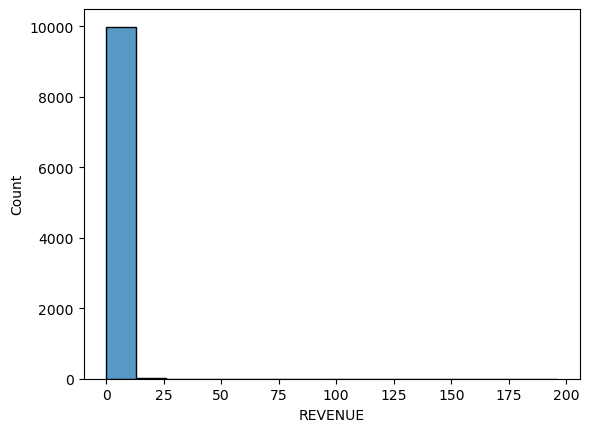

In [10]:
#visualize data distribution
sns.histplot(data["REVENUE"], kde=False)

In [11]:
print(data[data["REVENUE"]==0]["REVENUE"].value_counts().head()/data.shape[0]*100)
print((data[(data["REVENUE"]>0) & (data["REVENUE"]<1)]["REVENUE"].value_counts()/data.shape[0] * 100).sum())

REVENUE
0.0    98.48
Name: count, dtype: float64
0.2


*Surprisingly 98,48% of the users generate 0 revenue and 0,2% users gives near zero (0 - 1) revenue. Which indicates, only 1.5% users generate  revenue that value >= 1*

<Axes: title={'center': 'Revenue of variant and control group'}, xlabel='VARIANT_NAME', ylabel='REVENUE'>

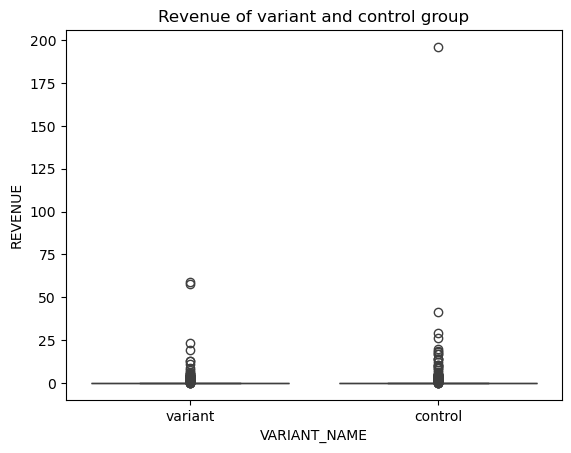

In [12]:
# Create the boxplot of the data
plt.title('Revenue of variant and control group')
sns.boxplot(data=data, x="VARIANT_NAME", y="REVENUE")

Outliers are dominant and unavoidable. Both control and variant have high-value users and the box (IQR) is basically accumulated on 0.

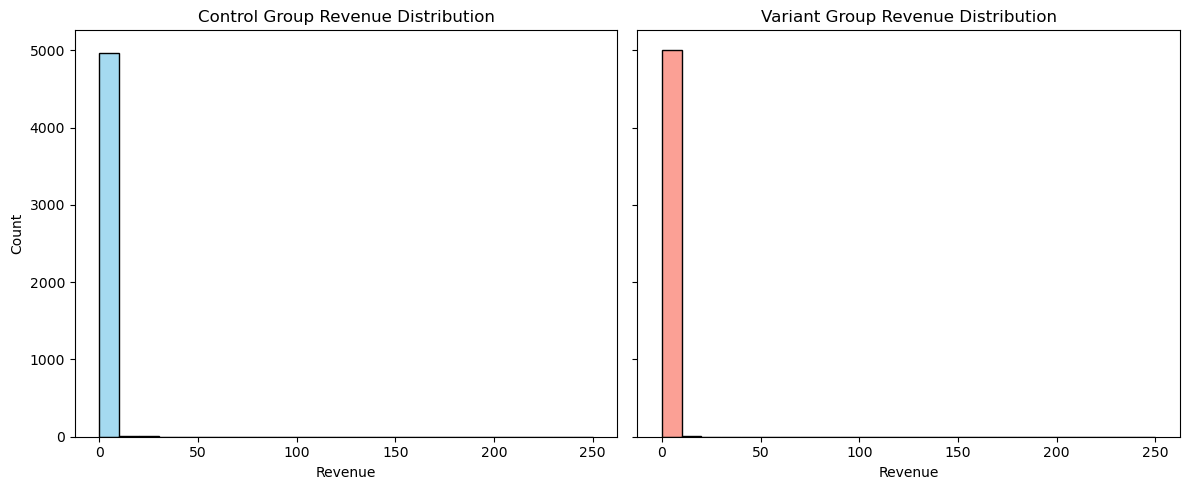

VARIANT_NAME  REVENUE
control       0.0        49.04
variant       0.0        49.44
Name: count, dtype: float64


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Control group
sns.histplot(
    data=data[data["VARIANT_NAME"] == "control"],
    x="REVENUE", bins=np.arange(0, 251, 10), ax=axes[0], color="skyblue")
axes[0].set_title("Control Group Revenue Distribution")
axes[0].set_xlabel("Revenue")
axes[0].set_ylabel("Count")

# Variant group
sns.histplot(
    data=data[data["VARIANT_NAME"] == "variant"],
    x="REVENUE", bins=np.arange(0, 251, 10), ax=axes[1], color="salmon")
axes[1].set_title("Variant Group Revenue Distribution")
axes[1].set_xlabel("Revenue")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

print(data[data["REVENUE"]==0].groupby('VARIANT_NAME')["REVENUE"].value_counts().head()/data.shape[0]*100)

The entire distribution is jammed near zero, and the y-axis shoots up aproximately to 5,000 record counts for both groups.

##### **3c. Insights from EDA processs**
1. Almost all users (98,5% of records) generate zero revenue and 0,2% users generate near-zero revenue
3. Almost ~49% users of total users from each group generate zero revenue
4. Although the revenue distribution contains extreme outliers, these likely represent high-value customers

In [14]:
# === Helper functions: effect sizes, bootstrap CI, saving ===
import math
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

def bootstrap_median_ci(x, n_boot=n_boot, alpha=alpha, seed=seed):
    """Return (lo, hi) bootstrap CI for median from 1D iterable x."""
    x = np.array(x)
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True)
    medians = np.median(boots, axis=1)
    lo = np.percentile(medians, 100*(alpha/2))
    hi = np.percentile(medians, 100*(1-alpha/2))
    return lo, hi

def prop_diff_ci(counts, nobs, alpha=0.05):
    """Approx normal CI for difference in proportions (p2 - p1). 
    counts = [c1, c2], nobs = [n1, n2] where group order must match your usage."""
    c1, c2 = counts
    n1, n2 = nobs
    p1 = c1 / n1
    p2 = c2 / n2
    diff = p2 - p1
    se = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = 1.96  # 95% CI
    return diff, diff - z*se, diff + z*se

def rank_biserial_from_U(U, n1, n2):
    """Rank-biserial effect size from Mann-Whitney U."""
    # formula 1 - 2U/(n1*n2)
    return 1 - (2*U) / (n1 * n2)

def save_fig(fig, filename, dpi=150):
    """Save matplotlib figure to results dir."""
    path = os.path.join(RESULTS_DIR, filename)
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    print("Saved:", path)
    return path

****

### **4. How different are zero vs non-zero revenue users?**

In [15]:
ovr_avg_median = data.groupby("VARIANT_NAME")["REVENUE"].agg(['mean','median']) # this include all the zero revenue
paid_avg_median = data[data["REVENUE"]>0].groupby("VARIANT_NAME")["REVENUE"].agg(['mean','median']) # this include  only non zero revenue

summary = pd.merge(ovr_avg_median, paid_avg_median, on = "VARIANT_NAME")
summary.columns = ["avg_ovr_revenue", "median_ovr_revenue", "avg_paid_revenue","median_paid_revenue"]
summary

,avg_ovr_revenue,median_ovr_revenue,avg_paid_revenue,median_paid_revenue
VARIANT_NAME,,,,
control,0.1290,0.0,8.0375,2.96
variant,0.0701,0.0,4.8815,2.17


In [16]:
print("Result Summary:")
print("The average overall revenue difference of both group is:", "{:.2f}".format(summary.iloc[0,0] - summary.iloc[1,0]))
print("The overall paid revenue difference of both group is:", "{:.2f}".format(summary.iloc[0,2] - summary.iloc[1,2]))
print("The median paid revenue difference of both group is:", "{:.2f}".format(summary.iloc[0,3] - summary.iloc[1,3]))
print("The median of overall revenue are equally 0")

Result Summary:
The average overall revenue difference of both group is: 0.06
The overall paid revenue difference of both group is: 3.16
The median paid revenue difference of both group is: 0.79
The median of overall revenue are equally 0


In [17]:
#Summary of ARPU and AOV
arpu = data.groupby('VARIANT_NAME')['REVENUE'].mean() # ARPU = average revenue per user (includes zeros)

aov = data[data['REVENUE']>0].groupby('VARIANT_NAME')['REVENUE'].mean() # AOV = average order value (only payers)
print("ARPU:\n", "\n",arpu,"\n==============================")
print("AOV (payers):\n", "\n", aov)

ARPU:
 
 VARIANT_NAME
control    0.1290
variant    0.0701
Name: REVENUE, dtype: float64 
AOV (payers):
 
 VARIANT_NAME
control    8.0375
variant    4.8815
Name: REVENUE, dtype: float64


### **5. Determining statistical test to use**

Before selecting a statistical test, a researcher has to simply answer the following six questions, which will lead to correct choice of test.  

1. How many independent variables (IV) covary (vary in the same time period) with the dependent variable? **One variable IV, the variant name**
2. At what level of measurement is the independent variable (IV)? The IV is variant name, which consist **two category (or binary)**
3. What is the level of measurement of the dependent variable (DV)?
   The DV is revenue value which **continuous**  
4. Are the observations **independent** or **dependent**? Control and variant group are **Independent** to each other
5. Do the comparisons involve populations to populations, a sample to a population, or are two or more samples compared? A/B Test is comparing **two sample** scenario (control and variant).
6. Is the hypothesis being tested **comparative** or **relationship**? **Comparative**, we compare of control or variant group performs differently
   
Unpaired 2  sample t - test mean checked all the requirements above. ***However...*** since the revenue data distribution is *highly positive skewed*, ***proportion Z test*** or ***Mann-Whitney U test*** is much more suitable to use.

Reference: Parab, S., & Bhalerao, S. (2010). Choosing the correct statistical test: A decision-making flowchart. *International Journal of Hygiene and Environmental Health*, [volume(issue)], pages. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2996580/ PMID:21170214

### **5. Hypothesis Testing - Is there a relationship between control and variant groups?**

#### 5a. Segmentation of the users
Let’s break the population into:
1. Non-converters user : Revenue = 0
2. Converters user: Revenue > 0

In [18]:
data['paid'] = data['REVENUE'] > 0 #adding boolean paid column
print(data[data['paid'] == True])
print(f"Data type is {data['paid'].dtype}, total converter users are {data['paid'].sum()} and the total records are {len(data)}")

      USER_ID VARIANT_NAME  REVENUE  paid
13       2529      variant     2.15  True
49       6429      control     3.25  True
139      3331      variant     4.27  True
149      8110      variant     1.75  True
152      8607      control     2.99  True
...       ...          ...      ...   ...
9651     9928      variant     1.25  True
9711     6468      control     2.93  True
9724     5205      control    14.17  True
9725      702      variant     2.92  True
9977     4678      variant     1.01  True

[152 rows x 4 columns]
Data type is bool, total converter users are 152 and the total records are 10000


**Out of 10000 records, only 152 users that has revenue > 0**


<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

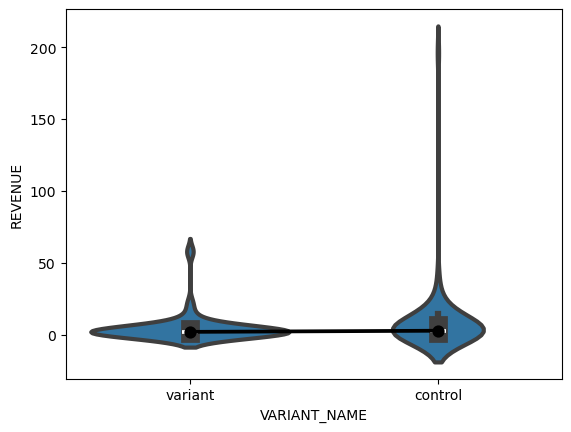

In [19]:
#Create violin plot
paid_users = data[data['paid'] == True]

sns.violinplot(x="VARIANT_NAME", y="REVENUE", data=paid_users, inner="box", cut=2, linewidth=3)
sns.pointplot(x="VARIANT_NAME", y="REVENUE", data=paid_users, estimator=np.median, color='k')
#plt.yscale('log'), I decide  ylog-scale is optional

In [20]:
control_revenue = paid_users[paid_users['VARIANT_NAME'] == 'control']['REVENUE']
variant_revenue = paid_users[paid_users['VARIANT_NAME'] == 'variant']['REVENUE']

The violin plots shows the distribution of paid users revenue is very concentrated around near zero, but few users generate revenue > 50, even higher that 200

#### 5b. Calculate conversion rate

In [21]:
# Conversion rate by group
conversion_rate = data.groupby('VARIANT_NAME')['paid'].agg(['mean','sum', 'count']).reset_index()
conversion_rate.columns = ['Group','Conversion_Rate', 'Conversions', 'Total']
print(conversion_rate)

# conversion_rate = (# of users with REVENUE > 0) / (total users in group)

     Group  Conversion_Rate  Conversions  Total
0  control           0.0161           80   4984
1  variant           0.0144           72   5016



#### 5c. A/B test using proportion Z-test

In [22]:
from statsmodels.stats.proportion import proportions_ztest

conversions = conversion_rate["Conversions"]
totals = conversion_rate["Total"]

# Run the test
z_stat, p_value = proportions_ztest(count=conversions, nobs=totals, alternative='two-sided')
print(f"Z-stat = {z_stat:.4f}, p-value = {p_value:.4f}")

Z-stat = 0.6936, p-value = 0.4879


In [23]:
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference of conversion rate between group and does not occur by chance.")
else:
    print("Fail to reject the null: No significant difference detected of conversion rate between group and the difference occur by chance.")

Fail to reject the null: No significant difference detected of conversion rate between group and the difference occur by chance.


**Because p > alpha the conclusion is fail to reject null hypothesis, there’s no strong statistical evidence to conclude that conversion rate differs significantly between control and variant users group.**  


*However, is it confirmed that the difference between group is not worth acting on based on the effect size?*  
For proportion Z-Test, I use this test to answer above question:
1. Absolute difference (p2 − p1) → in percentage points.
2. Relative difference (relative lift) = (p2 − p1) / p1.
3. Cohen’s h → standardized measure for comparing two proportions.

Thresholds (Cohen, 1988):  
|h| ≈ 0.20 → small effect  
|h| ≈ 0.50 → medium effect  
|h| ≈ 0.80 → large effect  

Anything < 0.10 is basically noise (negligible).

In [24]:
# Conversion counts from dataset
c1, n1 = conversions[0], totals[0] # control: conversions, total
c2, n2 = conversions[1], totals[1] # variant: conversions, total

p1 = c1 / n1
p2 = c2 / n2
abs_diff = p2 - p1
rel_lift = (abs_diff / p1) if p1 != 0 else float('nan')

# Cohen's h for proportions
import math
h = 2 * math.asin(math.sqrt(p2)) - 2 * math.asin(math.sqrt(p1))

In [25]:
print("=== Conversion (control vs variant) - Summary ===")
print("N_control =", n1, "N_variant =", n2, "\nConversions control =", c1, "variant =", c2)
print(f"control p1 = {p1:.6f} ({p1*100:.4f}%)")
print(f"variant p2 = {p2:.6f} ({p2*100:.4f}%)")
print(f"absolute difference (variant - control) = {abs_diff:.6f} ({abs_diff*100:.4f} percentage points)")
print(f"relative lift = {rel_lift*100:.2f}%")
print(f"Cohen's h = {h:.6f} ~ {h:.3f}")

=== Conversion (control vs variant) - Summary ===
N_control = 4984 N_variant = 5016 
Conversions control = 80 variant = 72
control p1 = 0.016051 (1.6051%)
variant p2 = 0.014354 (1.4354%)
absolute difference (variant - control) = -0.001697 (-0.1697 percentage points)
relative lift = -10.57%
Cohen's h = -0.013877 ~ -0.014


In [26]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

power = 0.8 # desired power
analysis = NormalIndPower() # Power analysis object

# mde effect size
effect_size_needed = analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=alpha,
    power=power, 
    ratio=n2/n1,
    alternative='two-sided')

def cohens_h_to_proportions(h, p1):
    return (np.sin(h / 2 + np.arcsin(np.sqrt(p1))))**2

In [27]:
# Calculate MDE in percentage points
p2_needed = cohens_h_to_proportions(effect_size_needed, p1)
mde_pp = abs(p2_needed - p1) * 100

# Also calculate actual Cohen's h for observed p1 vs p2 (optional)
observed_p2 = p2
h_observed = proportion_effectsize(p1, observed_p2)

required_n = analysis.solve_power(effect_size=proportion_effectsize(p1, p2), # Calculate absolute effect size in Cohen's h
                                  alpha=alpha, power=power, ratio=1.0, alternative='two-sided')

# Output
print(f"Baseline rate: {p1*100:.2f}%")
print(f"MDE (with current N, 80% power, α=0.05): {mde_pp:.2f} percentage points")
print(f"Required Cohen's h: {effect_size_needed:.4f}")
print(f"Observed Cohen's h: {h_observed:.4f}")
print(f"Required number sample: {required_n:.0f}")

Baseline rate: 1.61%
MDE (with current N, 80% power, α=0.05): 0.78 percentage points
Required Cohen's h: 0.0560
Observed Cohen's h: 0.0139
Required number sample: 81518


The Cohen’s h
, which measures the difference between two proportions on a standardized scale is so small almost negligible.  Meaning the observed lift between control and variant conversion rates is minuscule. Since both Cohen's h and observed cohen's h (0.0139) < required cohen's (0,056), the sample size is underpowered for this observed difference with 80% power.

Required_n = 81,518 per group -> This is how many samples needed in each group to reliably detect an effect of that small size with 5% significance level & power of 0.8 (80% chance of detecting it if it’s real)  
In other words, I currently have ~5,000 per group **which would need over 16× more data to have a decent chance of finding that tiny effect significant.**

The actual absolute difference in conversion rate between control (1.61%) and variant (1.43%) = 0.18 percentage points. Much smaller than MDE (0,78), so it’s no surprise result of p-value wasn’t significant (> 5%) & CI straddled zero

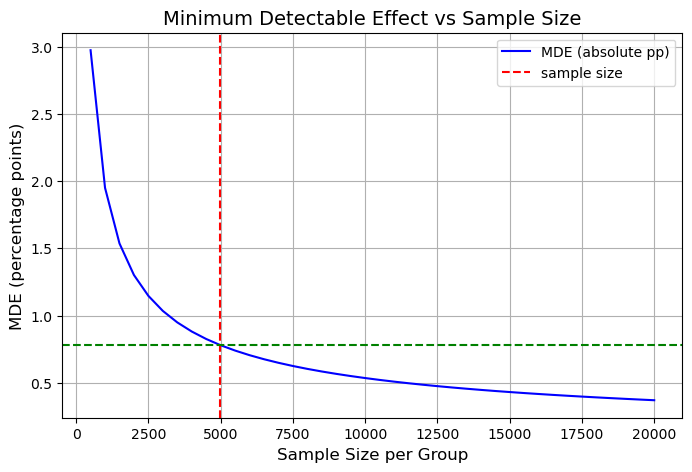

In [28]:
# Parameters from your dataset
baseline_rate = p1

# Sample sizes to try (per group)
sample_sizes = np.arange(500, 20001, 500)

# Calculate MDE (absolute percentage points) for each sample size
mde_pp = []
for n in sample_sizes:
    # Find effect size (Cohen's h) given power and sample size
    effect_size = analysis.solve_power(
        effect_size=None,
        nobs1=n,
        alpha=alpha,
        power=power,
        ratio=1.0,
        alternative='two-sided')
    # Convert Cohen's h back to absolute difference in proportions
    p_variant = np.sin(effect_size / 2 + np.arcsin(np.sqrt(baseline_rate)))**2
    diff_pp = abs(p_variant - baseline_rate) * 100  # in percentage points
    mde_pp.append(diff_pp)

# Plot
plt.figure(figsize=(8,5))
plt.plot(sample_sizes, mde_pp, label='MDE (absolute pp)', color='blue')
plt.axvline(x=4984, color='red', linestyle='--', label='sample size')
plt.axhline(y=mde_pp[np.where(sample_sizes == 5000)[0][0]], color='green', linestyle='--')

plt.title('Minimum Detectable Effect vs Sample Size', fontsize=14)
plt.xlabel('Sample Size per Group', fontsize=12)
plt.ylabel('MDE (percentage points)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

**Result interpretation:**
1. Control conversion p1 = 80 / 4984 ≈ 0.016051 → 1.6051%
2. Variant conversion p2 = 72 / 5016 ≈ 0.014354 → 1.4354%
3. Absolute difference (variant − control) = d ≈ −0.001697 → −0.1697 percentage points (pp).  
   Variant’s conversion is about 0.17 pp lower than control in the sample.
5. Relative difference (lift) = −0.1057 → −10.6%.  
Variant has about a 10.6% **lower conversion rate relative to control**.
6. Cohen’s h = −0.0139 ~ -0,014 (very small). This means even if the drop were real, it’s too small to matter for most decisions.
7. I would need over 16× more data (81.518 per group) to have a decent chance of finding that tiny effect significant

If this were a real business experiment, there are several choices can be called:
1. Increase N massively → run the test longer, get ~81k users per group.
2. Accept lower power → risk missing the effect (more false negatives).
3. Stop testing → if the effect is too small to matter financially, it’s not worth chasing.

****


#### 5d. A/B test using Mann Whitney U Test

In [29]:
from scipy.stats import mannwhitneyu

In [30]:
revenue_summary = paid_users.groupby('VARIANT_NAME')['REVENUE'].agg(['count', 'mean', 'median']).reset_index()
revenue_summary.columns = ['Group', 'Count', 'Mean_Revenue', 'Median_Revenue']
print(revenue_summary)

     Group  Count  Mean_Revenue  Median_Revenue
0  control     80        8.0375            2.96
1  variant     72        4.8815            2.17


In [31]:
stat, mw_p = mannwhitneyu(control_revenue, variant_revenue, alternative='two-sided')

print("Mann-Whitney context: paying control =", len(control_revenue), "variant =", len(variant_revenue))

Mann-Whitney context: paying control = 80 variant = 72


In [32]:
if mw_p < alpha:
    print("Reject the null hypothesis: There is a significant difference revenue between paying users and does not occur by chance.")
else:
    print("Fail to reject the null: No significant difference detected of revenue between paying users and the difference occur by chance.")

Fail to reject the null: No significant difference detected of revenue between paying users and the difference occur by chance.


**Because p > alpha the conclusion is fail to reject null hypothesis, there’s no strong statistical evidence to conclude that revenue between paying users control and variant group differs significantly**

However, is it confirmed that the difference between group is not worth acting on based on the effect size?  
For Mann-Whitney, I use Rank-biserial effect size to answer above question:

In [33]:
# Mann-Whitney rank-biserial from U (use the U you got for control)
n1 = len(control_revenue)
n2 = len(variant_revenue)
U = stat
# rank-biserial:
rank_biserial = 1 - (2*U)/(n1*n2)

print("\n=== Revenue among paying users (Mann-Whitney effect) ===")
print("Mann-Whitney: paying users control =", n1, "& variant =", n2)
print("Observed U =", U, "p =", mw_p)
print(f"U (for control) = {U}")
print(f"rank-biserial = {rank_biserial:.6f}, negative means effect size of variant > control (if passed control first to mannwhitneyu syntax)")


=== Revenue among paying users (Mann-Whitney effect) ===
Mann-Whitney: paying users control = 80 & variant = 72
Observed U = 3356.0 p = 0.07924299810603058
U (for control) = 3356.0
rank-biserial = -0.165278, negative means effect size of variant > control (if passed control first to mannwhitneyu syntax)


**Result Interpretation**  
Mann–Whitney’s U tells whether ranks differ,  
but I also want a standardized effect size: using rank-biserial one common, interpretable measure. It ranges roughly from −1 to +1:
1. Positive → group 1 tends to have higher values.
2. Negative → group 2 tends to have higher values.
3. Magnitude interpretation is context-dependent: ~0.1 small, 0.3 medium, 0.5 large (very rough).

Negative value (−0.165) means the variant tended to have higher ranks (higher revenue) than control.  
**This means although fewer people in variant converted (conversion metric), among those who did convert variant payers tended to spend slightly more and but the difference magnitude is modest**.

In [34]:
# Filter to only paying users
ctrl = control_revenue.to_numpy()
var  = variant_revenue.to_numpy()
print("paying users: control =", len(ctrl), ", variant =", len(var))

paying users: control = 80 , variant = 72


Observed median (variant - control): -0.790
95% bootstrap CI for median revenue difference among payers: [-1.730, 0.530]
Approx bootstrap p-value (two-sided): 0.4030


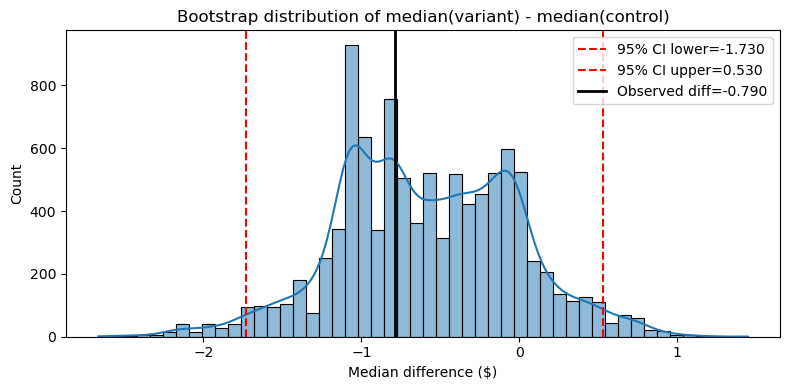

In [35]:
boot_diffs = []

# observed statistic (report this)
obs_diff = np.median(var) - np.median(ctrl)
print(f"Observed median (variant - control): {obs_diff:.3f}")

# bootstrap for loop
for i in range(n_boot):
    boot_control = rng.choice(ctrl, size=len(ctrl), replace=True)
    boot_variant = rng.choice(var, size=len(var), replace=True)
    diff = np.median(boot_variant) - np.median(boot_control)
    boot_diffs.append(diff)

# Compute CI
ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
print(f"95% bootstrap CI for median revenue difference among payers: [{ci_lower:.3f}, {ci_upper:.3f}]")

# Approximate bootstrap p-value (two-sided)
# proportion of bootstrap diffs as or more extreme than observed (symmetrical method)
p_hat = np.mean(np.abs(boot_diffs) >= np.abs(obs_diff))
print(f"Approx bootstrap p-value (two-sided): {p_hat:.4f}")

# Visualization
plt.figure(figsize=(8,4))
sns.histplot(boot_diffs, bins=50, kde=True)
plt.axvline(ci_lower, color='red', linestyle='--', label=f'95% CI lower={ci_lower:.3f}')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'95% CI upper={ci_upper:.3f}')
plt.axvline(obs_diff, color='black', linewidth=2, label=f'Observed diff={obs_diff:.3f}')
plt.title('Bootstrap distribution of median(variant) - median(control)')
plt.xlabel('Median difference ($)')
plt.legend()
plt.tight_layout()
plt.show()

The p-value (-0.790) is within the CI range (-1.730, 0.530) and the CI includes 0, it means revenue difference might be positive or negative **inconclusive whether the variant paying user boost relative more revenue**.
The result does support the Mann-Whitney U hypothesis test that there is no statistical difference of revenue among paying user. 

### **6. Conclusion**

There is no any supporting evidence that using variant enhancement or improvement generating more revenue since both Proportion Z-Test and Mann-Whitney U Test fail to reject the null hypotheses that states there is no difference in revenue between control and variant. From effect size test result, both test tell there is no enough magnitude difference to call action that worth the notice. Bootstrapping the median revenue CI for both group also support that there is inconclusive whether the variant group revenu differs significantly. 

Here is the final conclusion:
***Without statistical or business impact, there's no justification for further investment in this variant.***

In [36]:
# === Final summary and export for PPT / README ===
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu

# Ensure 'data' is loaded and 'paid' column exists
assert 'data' in globals(), "Load dataset into `data` first."
if 'paid' not in data.columns:
    data['paid'] = data['REVENUE'] > 0

# Basic group counts
group_counts = data['VARIANT_NAME'].value_counts().to_dict()
paid_counts = data.groupby('VARIANT_NAME')['paid'].sum().to_dict()

# conversion rates
conv_df = data.groupby('VARIANT_NAME')['paid'].agg(['sum','count']).reset_index()
conv_df.columns = ['Group','Conversions','Total']
conv_df['Conversion_Rate'] = conv_df['Conversions'] / conv_df['Total']

# ARPU / AOV / Median among payers
overall_avg = data.groupby("VARIANT_NAME")["REVENUE"].mean()
paid_only = data[data["REVENUE"]>0]
paid_stats = paid_only.groupby("VARIANT_NAME")["REVENUE"].agg(['count','mean','median']).rename(columns={'count':'Paying_Count'})

# z-test for proportions (conversion)
conversions = conv_df['Conversions'].tolist()
totals = conv_df['Total'].tolist()
z_stat, p_value = proportions_ztest(count=conversions, nobs=totals, alternative='two-sided')
prop_diff, ci_low, ci_high = prop_diff_ci(conversions, totals)

# Mann-Whitney among payers
ctrl = paid_only[paid_only['VARIANT_NAME']=='control']['REVENUE']
var  = paid_only[paid_only['VARIANT_NAME']=='variant']['REVENUE']
if len(ctrl)==0 or len(var)==0:
    mw_stat, mw_p = (np.nan, np.nan)
else:
    mw_stat, mw_p = mannwhitneyu(ctrl, var, alternative='two-sided')
# rank-biserial
rbs = rank_biserial_from_U(mw_stat, len(ctrl), len(var)) if not np.isnan(mw_stat) else np.nan

# bootstrap medians
ctrl_median_ci = bootstrap_median_ci(ctrl, n_boot, alpha, rng)
var_median_ci  = bootstrap_median_ci(var, n_boot, alpha, seed)

# Build summary DataFrame
summary = pd.DataFrame({
    'Group': ['control','variant'],
    'Total Users': [group_counts.get('control',0), group_counts.get('variant',0)],
    'Paying Users': [paid_counts.get('control',0), paid_counts.get('variant',0)],
    'Conversion Rate': [overall_avg.get('control',0), overall_avg.get('variant',0)],  # placeholder - will overwrite
})

# fix conversion rate cells properly (from conv_df)
for i,row in conv_df.iterrows():
    summary.loc[summary['Group']==row['Group'], 'Conversion Rate'] = row['Conversion_Rate']

# attach paying-user stats
for idx, r in paid_stats.reset_index().iterrows():
    grp = r['VARIANT_NAME']
    summary.loc[summary['Group']==grp, 'Paying_Mean'] = r['mean']
    summary.loc[summary['Group']==grp, 'Paying_Median'] = r['median']

# Add test results
summary_stats = {
    'conversion_z_stat': z_stat,
    'conversion_p_value': p_value,
    'conversion_diff': prop_diff,
    'conversion_diff_CI': (ci_low, ci_high),
    'mannwhitney_U': mw_stat,
    'mannwhitney_p': mw_p,
    'rank_biserial': rbs,
    'ctrl_median_ci': ctrl_median_ci,
    'var_median_ci': var_median_ci
}

# Save summary
summary_path = os.path.join(RESULTS_DIR, "ab_test_summary.csv")
summary.to_csv(summary_path, index=False)
with open(os.path.join(RESULTS_DIR, "ab_test_summary.json"), "w") as f:
    json.dump({'summary_table': summary.to_dict(orient='records'), 'summary_stats': summary_stats}, f, indent=2)

print("Summary saved:", summary_path)
print("Summary stats:", summary_stats)

# Prepare a short text snippet for the final slide (copy this into PPT)
slide_text = f"""
AB Test Summary (Control vs Variant)
------------------------------------
N (control) = {group_counts.get('control',0)}, N (variant) = {group_counts.get('variant',0)}
Paying users: control = {paid_counts.get('control',0)}, variant = {paid_counts.get('variant',0)}

Conversion rate: control = {conv_df.loc[conv_df.Group=='control','Conversion_Rate'].values[0]:.4%}, variant = {conv_df.loc[conv_df.Group=='variant','Conversion_Rate'].values[0]:.4%}
Conversion two-prop z-test: z = {z_stat:.4f}, p = {p_value:.4f}
Difference in proportions (variant - control) = {prop_diff:.4%}, 95% CI [{ci_low:.4%}, {ci_high:.4%}]

Revenue (paying users) — Mann-Whitney U: U = {mw_stat}, p = {mw_p:.4f}
Median revenue (paying users): control median CI = [{ctrl_median_ci[0]:.2f}, {ctrl_median_ci[1]:.2f}], variant median CI = [{var_median_ci[0]:.2f}, {var_median_ci[1]:.2f}]
Rank-biserial effect size = {rbs:.4f}
"""

# save slide text to file
with open(os.path.join(RESULTS_DIR,"slide_summary.txt"), "w") as f:
    f.write(slide_text)

print("Slide text saved to:", os.path.join(RESULTS_DIR,"slide_summary.txt"))
print("\nSlide text preview:\n")
print(slide_text)

Summary saved: results/ab_test_summary.csv
Summary stats: {'conversion_z_stat': np.float64(0.6936332570474268), 'conversion_p_value': np.float64(0.4879122318708867), 'conversion_diff': -0.0016972973803251728, 'conversion_diff_CI': (-0.0064940800407557, 0.0030994852801053546), 'mannwhitney_U': np.float64(3356.0), 'mannwhitney_p': np.float64(0.07924299810603058), 'rank_biserial': np.float64(-0.16527777777777786), 'ctrl_median_ci': (np.float64(2.17), np.float64(3.79)), 'var_median_ci': (np.float64(1.51), np.float64(2.975))}
Slide text saved to: results/slide_summary.txt

Slide text preview:


AB Test Summary (Control vs Variant)
------------------------------------
N (control) = 4984, N (variant) = 5016
Paying users: control = 80, variant = 72

Conversion rate: control = 1.6051%, variant = 1.4354%
Conversion two-prop z-test: z = 0.6936, p = 0.4879
Difference in proportions (variant - control) = -0.1697%, 95% CI [-0.6494%, 0.3099%]

Revenue (paying users) — Mann-Whitney U: U = 3356.0, p = 